# UW PCE DS 420- Homework 10
## Lukas Fiorio

In this homework, we take a sample of the IMDB dataset provided in TensorFlow Datasets to predict positive (1) or negative (0) sentiment. The data comes from http://ai.stanford.edu/~amaas/data/sentiment/ .

We start by creating a benchmark model. The benchmark model we create is a rule-based sentiment model, based on the number of positve and negative words in each review.

Next, we will make a RNN model. In fact, a nice RNN is made here in the TensorFlow Tutorials:
https://www.tensorflow.org/tutorials/text/text_classification_rnn

We modify this to align with the Lesson 10 lab to use a simple RNN over a pandas sample.

We will have to implement a basic cleaning, tokenizing, and embedding.

In [1]:
# Load Libraries
import os
import re
import nltk
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from numpy.random import seed

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator # integer tick labels

from sklearn.model_selection import train_test_split

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import treebank
from nltk.corpus import opinion_lexicon
from nltk.tokenize import word_tokenize

### Here we load the data.

The data comes in a nice format for setting up a test-preprocessing pipeline of data in the TF Dataset type.

But we want to try to use Pandas, so we'll convert it into a dataframe.

First, we load the data into our tf.dataset() objects.

In [2]:
# Setup the IMDB review data
# The IMDB review data contains 25,000 reviews in the train set. And also 25,000 reviews in the test set.

dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

### Convert / Sample into Pandas.DataFrame

Next we'll convert tf objects into pd dataframes (for the train and test set).  To expedite computations, we'll sample only a subset of the full datasets.

In [3]:
# We can take up to 25,000 of each. take subset to speed calculations.
train_count = 5000
test_count = 1000

# Setup Train DF
train_df = pd.DataFrame(columns=['review', 'label'])
for review, label in train_dataset.take(train_count):
    train_df = train_df.append({'review': review.numpy(), 'label': label.numpy()}, ignore_index=True)

# Setup Teset DF
test_df = pd.DataFrame(columns=['review', 'label'])
for review, label in test_dataset.take(test_count):
    test_df = test_df.append({'review': review.numpy(), 'label': label.numpy()}, ignore_index=True)

# Change to strings from the 'b' - binary columns
train_df['review'] = train_df['review'].str.decode("utf-8")
test_df['review'] = test_df['review'].str.decode("utf-8")  

Let's verify the output is as we expect (size and preview) - looks good.

In [4]:
# Check size and examples
print('Train shape: {}'.format(train_df.shape))
print('Test shape: {}'.format(test_df.shape))
pd.options.display.max_colwidth = None # show full review
train_df.head(n=4) # row 5 not SFW

Train shape: (5000, 2)
Test shape: (1000, 2)


,review,label
0,"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",0
1,"I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else. I cant recommend this film at all.",0
2,"Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town? <br /><br />Nothing even remotely resembling that happened on the Canadian side of the border during the Klondike gold rush. Mr. Mann and company appear to have mistaken Dawson City for Deadwood, the Canadian North for the American Wild West.<br /><br />Canadian viewers be prepared for a Reefer Madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust.",0
3,"This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. There are no rapids to cross, no dangerous waters, just a warm and witty paddle through New York life at its best. A family film in every sense and one that deserves the praise it received.",1


### Check for target imbalance problems.

Next we check for the balance/makeup of the target values to see if there exists any imbalance.  Our subsets appear to be balanced.

In [5]:
# Check target imbalance. No issues.
print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

1    2526
0    2474
Name: label, dtype: int64
0    503
1    497
Name: label, dtype: int64


Before we go any further, we'll set random seeds for replicability.

In [6]:
random_state = 99

# set seeds
seed(random_state)
tf.random.set_seed(random_state)

### Now we split the sets into train-validation-test

The data is already split into train-test. To make a validation set, we'll just the test set in half.

In [7]:
# Split into train-validation-test by taking half of the test set into validation
test_df, valid_df = train_test_split(test_df, test_size = 0.5, random_state = random_state)
test_df = test_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

Let's also preview the test set just to make sure it looks as expected (it does).

In [8]:
# check dimensions & preview test set
print('Test shape: {}'.format(test_df.shape))
print('Valid shape: {}'.format(valid_df.shape))
test_df.head(n=2) # very long reviews!

Test shape: (500, 2)
Valid shape: (500, 2)


review  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   I only saw the first part of this and concluded that I wouldn't miss anything if I didn't watch the second episode. The cinematography was OK, but apart from this, the plot was just as commonorgarden and run-of-the-mill as any other war story. The actors and actresses play their characters without any passion, and the make up is really bad (Heiner Lauterbach with his white hair and Kai Wiesinger respectively, as if some dyed white hair could give them more dignity and common sense). I mean if you've watched more than two or three movies about WWII (as most of us have) then you'd only go to the trouble of seeing a third or fourth one if it promises some new insights or twists in the plot. But Roland Suso Richter seems to afraid of doing so, you can almost smell his fear of not living up to the bourgeois and jejune expectations of the conservative ZDF TV channel while watching this movie. Millions of Euros were spent t

### Clean the text

We will clean the text by defining a function to apply these processing steps:

- lowercase the text
- remove ascii characters
- process the punctuation
- remove digits
- remove filler ("stop") words
- remove the extra whitespace

From our example reviews above, we saw that each of the above issues would need to be handled.

Note that order matters as each step depends on the input from the prior step.  We first import nltk dictionaries to assist with our pre-procesing.

First, let's download stopwords and an opinion lexicon from nltk.  These will be used in our rule based benchmark.

In [9]:
nltk.download('opinion_lexicon')
nltk.download('stopwords')

# store stop words
stop = stopwords.words('english') 

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     /Users/lukefiorio/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lukefiorio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


And now we define a function to apply the processing steps we listed above.

In [10]:
def clean_text(raw_text, omit_stop = True):

    # set all lower case
    clean_text = raw_text.str.lower()
    
    # remove ascii
    clean_text = clean_text.apply(lambda x: re.sub(r'[^\x00-\x7f]', r'', str(x)))
    
    # remove punctuation
    clean_text = clean_text.str.translate(str.maketrans('', '', string.punctuation))
    
    # remove digits
    clean_text = clean_text.apply(lambda x: re.sub(r'[\d]', r'', str(x)))
    
    # remove filler words (if specified)
    if omit_stop == True:
        clean_text = clean_text.apply(lambda x: ' '.join([s for s in x.split() if s not in stop]))
    
    # remove extra white space
    clean_text = clean_text.apply(lambda x: ' '.join(s for s in x.split()))

    return clean_text

And now apply that text processing to our train, validation, and test datasets.  Then we preview the cleaned training data.

In [11]:
# apply text processing
X_train_rule = clean_text(train_df['review'], omit_stop = True)
X_valid_rule = clean_text(valid_df['review'], omit_stop = True)
X_test_rule = clean_text(test_df['review'], omit_stop = True)

# preview clean text
X_train_rule.head(n=4)

0                                                           absolutely terrible movie dont lured christopher walken michael ironside great actors must simply worst role history even great acting could redeem movies ridiculous storyline movie early nineties us propaganda piece pathetic scenes columbian rebels making cases revolutions maria conchita alonso appeared phony pseudolove affair walken nothing pathetic emotional plug movie devoid real meaning disappointed movies like ruining actors like christopher walkens good name could barely sit
1                                                                                                                                                                            known fall asleep films usually due combination things including really tired warm comfortable sette eaten lot however occasion fell asleep film rubbish plot development constant constantly slow boring things seemed happen explanation causing admit may missed part film watched ma

Now we'll set aside our target values as well.

In [12]:
# store y in array
y_train_rule = np.asarray(train_df['label']).astype('float32')
y_valid_rule = np.asarray(valid_df['label']).astype('float32')
y_test_rule = np.asarray(test_df['label']).astype('float32')

### Create a rule-based benchmark

We earlier downloaded nltk's sentiment library.  Here we store those words in separate sets (for positive, negative connotation).

Then we define a function that returns the net score of cnt(positive words) minus cnt(negative words) in a string.

In [13]:
# store nltk lexicon/dictionary
pos_set = set(opinion_lexicon.positive())
neg_set = set(opinion_lexicon.negative())

# define function to score a string based on # of positive/negative words
def sentiment_base(my_string):
    # Get words
    words = [w for w in word_tokenize(my_string)]
    # Get + and - scores:
    pos_score = sum([1 if w in pos_set else 0 for w in words])
    neg_score = sum([1 if w in neg_set else 0 for w in words])
    return pos_score - neg_score

Apply our sentiment scoring function to the train, validation, and test datasets to obtain an overall sentiment score for each review.

In [14]:
# May take some time (~10-15 seconds)
y_train_rule_score = X_train_rule.apply(sentiment_base)
y_valid_rule_score = X_valid_rule.apply(sentiment_base)
y_test_rule_score = X_test_rule.apply(sentiment_base)

Finally, we convert those scores into a simple (0, 1) mapping and compare our predictions (based on our sentiment scores) to the actual labels.

Note that we predict ties (net score = 0) to be negative reviews.  We make this choice based on higher train set accuracy than predicting ties as positive. 

We obtain overall accuracy of ~73% on our train and validation sets and 70% on our test set.  Not bad!

In [15]:
# convert scores to predictions. (subtract -0.1 to treat ties as negative)
y_train_hat = np.sign(y_train_rule_score - 0.1).map({-1:0, 1:1})
y_valid_hat = np.sign(y_valid_rule_score - 0.1).map({-1:0, 1:1})
y_test_hat = np.sign(y_test_rule_score - 0.1).map({-1:0, 1:1})

# calculate accuracy
train_acc_rule = (y_train_hat == y_train_rule).astype('int')
valid_acc_rule = (y_valid_hat == y_valid_rule).astype('int')
test_acc_rule  = (y_test_hat  == y_test_rule).astype('int')

# print results
print('Accuracy -      train set:', round(train_acc_rule.mean(), 3))
print('Accuracy - validation set:', round(valid_acc_rule.mean(), 3))
print('Accuracy -       test set:', round(test_acc_rule.mean(), 3))

Accuracy -      train set: 0.733
Accuracy - validation set: 0.73
Accuracy -       test set: 0.698


## RNN

Now that we have our benchmark, let's trying build a recurrent neural network (RNN) model.

We'll start by re-cleaning our data, but this time leaving in stop words (rather than omitting them).  Given the sequential approach of RNN, keeping those stop words will help the model learn important ordering relationships.

In [16]:
# apply text processing
X_train_rnn = clean_text(train_df['review'], omit_stop = False)
X_valid_rnn = clean_text(valid_df['review'], omit_stop = False)
X_test_rnn = clean_text(test_df['review'], omit_stop = False)

# store target in separate array
y_train_rnn = np.asarray(train_df['label']).astype('float32')
y_valid_rnn = np.asarray(valid_df['label']).astype('float32')
y_test_rnn = np.asarray(test_df['label']).astype('float32')

Let's preview our cleaned train data.  We can see the inclusion of the stop words here (along with the removal of punctuation, lower-casing, etc.).

In [17]:
X_train_rnn.head(n=2)

0    this was an absolutely terrible movie dont be lured in by christopher walken or michael ironside both are great actors but this must simply be their worst role in history even their great acting could not redeem this movies ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the columbian rebels were making their cases for revolutions maria conchita alonso appeared phony and her pseudolove affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining actors like christopher walkens good name i could barely sit through it
1                                                                                            i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the sette and having just eaten a lot however on this occas

### Data Exploration

Next we'll examine our cleaned data to determine where to set thresholds on dictionary size and review length.

We'll start by looking into review length to determine where to cap our sequence length.

In [18]:
# count the nbr of chars/words in each review
review_len_char = X_train_rnn.str.len()
review_len_word = X_train_rnn.apply(lambda x: len(x.split(' ')))

To get a high level understanding of the sequence lengths, let's plot the distribution of each (character count and word count).

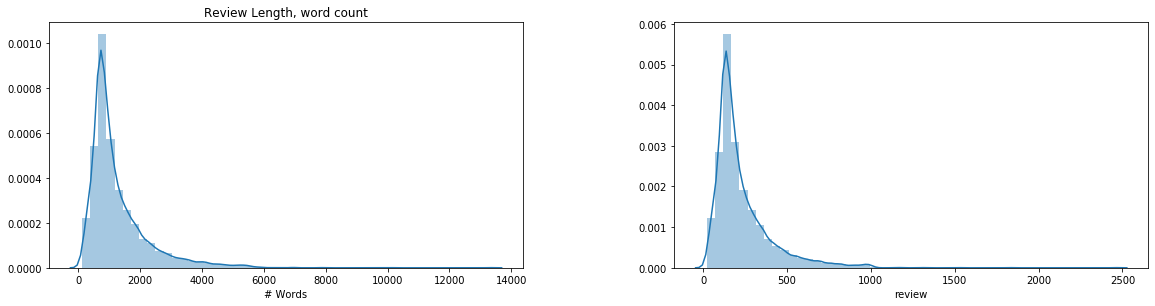

In [19]:
# set figure, axis properties
fig, ax = plt.subplots(ncols = 2, nrows = 1)
fig.set_size_inches(16, 4)
fig.tight_layout(h_pad = 6, w_pad = 12)
    
sns.distplot(review_len_char, ax = ax[0]);
ax[0].title.set_text('Review Length, character count');
ax[0].set_xlabel('# Characters');

sns.distplot(review_len_word, ax = ax[1]);
ax[0].title.set_text('Review Length, word count');
ax[0].set_xlabel('# Words');

We'll also take a more direct look at the # of words in each review.  Realistically we wouldn't build our rnn to sequentially loop through characters (we'll build it based on the **words** each review contains).

We see that 90% of reviews have more than 100 words and then a huge drop-off after that (only 40% with more than 200 words).  Based on this, we'll start off by setting our sequence length at 100.

We'll zero-pad any reviews shorter thann that, and truncate any reviews that go longer.  We can revisit this decision if our model isn't learning well.

In [20]:
print("% of reviews with more than ... WORDS")
print('-------------------------------------')
for i in (np.linspace(start=0, stop=1000, num = 11)):
    print(i.astype(int), '--', round((review_len_word > i).mean(), 3))

% of reviews with more than ... WORDS
-------------------------------------
0 -- 1.0
100 -- 0.881
200 -- 0.408
300 -- 0.225
400 -- 0.129
500 -- 0.076
600 -- 0.048
700 -- 0.029
800 -- 0.018
900 -- 0.01
1000 -- 0.002


Next, let's look into how many words we should include in our vocabulary dictionary.  We start by making a dataframe that holds each unique word and its number of occurences across all reviews.

In [21]:
# combine selected features into large list (with dupes)
all_words = X_train_rnn.str.split(' ').sum()

# apply counter to count # of occurences of each feature (while de-duping)
word_cnt_dict = Counter(all_words)
word_cnt_df = pd.DataFrame.from_dict(word_cnt_dict, orient='index').reset_index()

Let's take a peek at the 10 most common words... all of our stop words, which makes sense.

In [22]:
word_cnt_df.nlargest(10, 0)

,index,0
41,the,66637
59,and,32359
65,a,32324
70,of,29188
90,to,27115
35,is,21210
9,in,18219
86,it,15459
74,i,15413
0,this,15215


And on the flip side, looking at a subset of the less common words (which only have 1 occurence), we do see these words are relatively specific.

In [23]:
word_cnt_df.nsmallest(10, 0)

,index,0
48,columbian,1
61,pseudolove,1
171,mountie,1
177,elect,1
181,enforce,1
207,westbr,1
250,paddle,1
346,barometers,1
359,microscopically,1
360,gradations,1


We see that in total, there are about 50,000 unique words across our reviews.  To prevent overfitting, we'll want to limit that (i.e. limit our dictionary size) before running it through a RNN model.

In [24]:
len(word_cnt_df)

49976

Let's take a closer look at the distribution of review words.  First, how many of the words (across all reviews) show up once, 5x, 10x, ... , etc?

We can see that if we included only words that show up more than 50 times, our dictionary would be 2,000 words and we'd be capturing 4% of the unique words.

We also see that the vast majority of words (78%) show up 5 times or less.  Our dictionary would need to hold 11,000 words to capture those words.

This all seems a bit fuzzy, so let's take another look, but using a more "dictionary-size" centric view.

In [25]:
print("% of unique words with more than ... OCCURENCES")
print('-------------------------------------')
for i in (np.linspace(start=0, stop=50, num = 11)):
    print(i.astype(int),
          '--', 
          round(len(word_cnt_df[word_cnt_df[0] > i]) / len(word_cnt_df), 3),
          '|', len(word_cnt_df[word_cnt_df[0] > i])
         )

% of unique words with more than ... OCCURENCES
-------------------------------------
0 -- 1.0 | 49976
5 -- 0.22 | 10979
10 -- 0.139 | 6942
15 -- 0.103 | 5133
20 -- 0.082 | 4110
25 -- 0.069 | 3425
30 -- 0.06 | 2974
35 -- 0.053 | 2641
40 -- 0.047 | 2365
45 -- 0.043 | 2133
50 -- 0.039 | 1950


We can also look to see how a dictionary of size 1K, 2K, ..., etc would capture both the number of *unique* words **and** the number of *total* words in our reviews.

Based on this, we'll start out by keeping 3,000 words in our dictionary.  This will represent 80% of all words, even though it's only 6% of unique words!

In [26]:
print("% of words covered at each vocab size")
print('-------------------------------------')
print('dict_size | pct_unique | pct_total')
print('-------------------------------------')
for i in (np.linspace(start=0, stop=10000, num = 11)):
    print(i.astype(int),
          '|', 
          round(i / len(word_cnt_df), 3),
          '|',
          round(word_cnt_df[:i.astype(int)][0].sum() / word_cnt_df[0].sum(), 3),
         )

% of words covered at each vocab size
-------------------------------------
dict_size | pct_unique | pct_total
-------------------------------------
0 | 0.0 | 0.0
1000 | 0.02 | 0.659
2000 | 0.04 | 0.741
3000 | 0.06 | 0.788
4000 | 0.08 | 0.819
5000 | 0.1 | 0.843
6000 | 0.12 | 0.861
7000 | 0.14 | 0.874
8000 | 0.16 | 0.885
9000 | 0.18 | 0.895
10000 | 0.2 | 0.903


Now that we've got a sense of the distribution of words across reviews, let's make a Tokenizer.

This will allow us to convert specific words (those stored in our dictionary) into indices.  Based on the exploration above, we'll keep the most common 2,999 words (+1 "unknown" category for all other words).

In [27]:
# Setup a vocab embedding
max_vocab_size = 3000

# Initialize our encoder - keep 2999 words (+"unknown")
k_tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<unk>')

# Fit our tokenizer
k_tokenizer.fit_on_texts(X_train_rnn)

# Convert to sequences
X_train_seq = k_tokenizer.texts_to_sequences(X_train_rnn)
X_valid_seq = k_tokenizer.texts_to_sequences(X_valid_rnn)
X_test_seq = k_tokenizer.texts_to_sequences(X_test_rnn)

Take a look at our first review to compare the original review to the tokenized review.  We see a fair amount of unknown tokens (1), but not *too* many.

In [28]:
print(X_train_rnn[0].split())
print('\n', X_train_seq[0])

['this', 'was', 'an', 'absolutely', 'terrible', 'movie', 'dont', 'be', 'lured', 'in', 'by', 'christopher', 'walken', 'or', 'michael', 'ironside', 'both', 'are', 'great', 'actors', 'but', 'this', 'must', 'simply', 'be', 'their', 'worst', 'role', 'in', 'history', 'even', 'their', 'great', 'acting', 'could', 'not', 'redeem', 'this', 'movies', 'ridiculous', 'storyline', 'this', 'movie', 'is', 'an', 'early', 'nineties', 'us', 'propaganda', 'piece', 'the', 'most', 'pathetic', 'scenes', 'were', 'those', 'when', 'the', 'columbian', 'rebels', 'were', 'making', 'their', 'cases', 'for', 'revolutions', 'maria', 'conchita', 'alonso', 'appeared', 'phony', 'and', 'her', 'pseudolove', 'affair', 'with', 'walken', 'was', 'nothing', 'but', 'a', 'pathetic', 'emotional', 'plug', 'in', 'a', 'movie', 'that', 'was', 'devoid', 'of', 'any', 'real', 'meaning', 'i', 'am', 'disappointed', 'that', 'there', 'are', 'movies', 'like', 'this', 'ruining', 'actors', 'like', 'christopher', 'walkens', 'good', 'name', 'i', '

And for simplicity, we can also compare the Tokenization of a much simpler string, too.  In this case, only `'snuffalufagus'` is unknown.

In [29]:
example_review = 'i loved this movie so much snuffalufagus'

# Test encoding-> Any unknown word should get mapped to '1'
encoded_example = k_tokenizer.texts_to_sequences([example_review])
encoded_example

[[10, 423, 11, 19, 38, 73, 1]]

Now let's incorporate our exploration from earlier, setting the max review length at 100 and zero-padding reviews shorter than that.

In [30]:
max_sequence_len = 100

# Add padding after sequences or cutoff to limit length.
# Padding can be before or after sequence. We want to pad w/ zeros after.
X_train_padded = pad_sequences(X_train_seq, padding='post', maxlen=max_sequence_len)
X_valid_padded = pad_sequences(X_valid_seq, padding='post', maxlen=max_sequence_len)
X_test_padded = pad_sequences(X_test_seq, padding='post', maxlen=max_sequence_len)

Let's take a look at a couple of arbitrary review encodings.  This first one has a length of 100 and is pretty heavily padded with 0's.

In [31]:
print(X_train_padded[404])
print(X_train_padded[404].shape)

[ 620   57   43   24  169  911    1   11   19    7  364  679    2  142
   16  321    1   98   59   17    1   29    5    2  284  777  248 2966
   36    2  836 1172    1    1  156  111 1958    3    1  163  946    3
 1063    3    9    7 1305  242    6  103    2 2740   25    2  110    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
(100,)


This next one *also* has a length of 100, but we notice this one did *not* need to be zero-padded.  In fact, we likely cut off some of the review - even still, hopefully the first 100 words will be enough for the model to learn its sentiment.

In [32]:
print(X_train_padded[999])
print(X_train_padded[999].shape)

[   4  146  467 1705   29  264  267   33 1715    1   58   26  222  244
   16 1967   41   17   12  548  253   37    7   22    4    1  467    8
    2   77 1735  290    2  246    5   11 1286 2034    1  128  841   31
  226  280  210    1    6  490 1979   13  369 2034    1    3   28    7
   44    6  490 1967   53   24    1    9   28    7  333   33    1   13
   38 1747   54    1    1    1    6 1139    6  201   41  264   28  137
   72  300   16  524    1   37  549    2 1244  372    2 1109    3   98
  732 1109]
(100,)


*FYI: reset RNN model if needed*

In [33]:
# clear model (if necessary)
tf.keras.backend.clear_session()

Now we're ready to build a RNN model.  We start by adding an embedding layer with input dimensions matching the size of our dictionary (`3000`).

We set our output dimension to size 8 to do our best to help with overfitting (the higher the dimension size, the more complexity can be modeled).

Next we'll add an LSTM layer (long short term memory) to help control where hidden layers weights are updated and by how much. At this point we'll also add dropout (at a relatively high rate of 50%) to again try to help with overfitting.

Lastly we'll add our output layer, with a single unit (since this is a binary problem).

In [34]:
# Initialize model
rnn_model = tf.keras.Sequential()

# Embedding layer w input dim size = 3000 (dictionary size)
# output embedding dime size = 8
rnn_model.add(layers.Embedding(input_dim=max_vocab_size, output_dim=8))

# Add a LSTM layer with 64 internal units.
rnn_model.add(layers.LSTM(64))
rnn_model.add(Dropout(0.5))

# Add a Dense layer with 1 unit.
rnn_model.add(layers.Dense(1, activation='sigmoid'))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 8)           24000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                18688     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 42,753
Trainable params: 42,753
Non-trainable params: 0
_________________________________________________________________


We'll initialize our optimizer outside of `model.fit()` so that we can specify the learning rate.  Since this is a binary problem, we'll use `BinaryCrossentropy` (as opposed to categorical).

In [35]:
# initialize
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# compile
rnn_model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = opt,
    metrics = ["accuracy"],
)

And fitting our model, we see decent learning ability.  It looks like the vast majority of learning happened in the ~5 epcohs, but we'll next define some functions to examine more closely.

In [36]:
# fit model
model_logs = rnn_model.fit(X_train_padded, y_train_rnn,
                           validation_data=(X_valid_padded, y_valid_rnn),
                           batch_size=64,
                           epochs=15)

Epoch 1/15
79/79 [==============================] - 4s 53ms/step - loss: 0.6929 - accuracy: 0.5046 - val_loss: 0.6921 - val_accuracy: 0.5120
Epoch 2/15
79/79 [==============================] - 4s 45ms/step - loss: 0.6844 - accuracy: 0.5698 - val_loss: 0.6728 - val_accuracy: 0.6700
Epoch 3/15
79/79 [==============================] - 4s 48ms/step - loss: 0.5137 - accuracy: 0.7700 - val_loss: 0.6141 - val_accuracy: 0.7440
Epoch 4/15
79/79 [==============================] - 4s 46ms/step - loss: 0.3766 - accuracy: 0.8438 - val_loss: 0.4808 - val_accuracy: 0.7700
Epoch 5/15
79/79 [==============================] - 4s 47ms/step - loss: 0.2869 - accuracy: 0.8896 - val_loss: 0.6201 - val_accuracy: 0.7520
Epoch 6/15
79/79 [==============================] - 4s 47ms/step - loss: 0.2449 - accuracy: 0.9144 - val_loss: 0.5349 - val_accuracy: 0.7740
Epoch 7/15
79/79 [==============================] - 4s 47ms/step - loss: 0.2007 - accuracy: 0.9290 - val_loss: 0.6617 - val_accuracy: 0.7580
Epoch 8/15
79

This function will help visualize how the neural network is learning over each epoch. We'll also report out how the final epoch performed on the validation set.

In [37]:
def model_plots(model, test_set="Test"):

    # cnt of epochs
    epochs = len(model.history['accuracy'])
    final_valid_acc = model.history['val_accuracy'][epochs-1]
    final_valid_loss = model.history['val_loss'][epochs-1]
    
    # set figure, axis properties
    fig, ax = plt.subplots(ncols = 2, nrows = 1)
    fig.set_size_inches(16, 4)
    fig.tight_layout(h_pad = 6, w_pad = 12)

    # make accuracy plot
    sns.lineplot(x = range(1, epochs + 1), y = model.history['accuracy'], ax = ax[0], label = "Train");
    sns.lineplot(x = range(1, epochs + 1), y = model.history['val_accuracy'], ax = ax[0], label = test_set);
    ax[0].title.set_text('Model Accuracy');
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0].set_xlabel('Epochs')
    ax[0].legend();
    
    # make loss plot
    sns.lineplot(x = range(1, epochs + 1), y = model.history['loss'], ax = ax[1], label = "Train");
    sns.lineplot(x = range(1, epochs + 1), y = model.history['val_loss'], ax = ax[1], label = test_set);
    ax[1].title.set_text('Model Loss');
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].set_xlabel('Epochs')
    ax[1].legend();
    
    # print final stats
    print('\n', test_set, 'Accuracy:', round(final_valid_acc, 3),'\n', test_set, 'Loss:', round(final_valid_loss, 3))

In our model, we see a pretty large gap open up between the accuracy/loss metrics on the Train data vs. the Validation data around the 4th epoch.

We took several steps to try to regularize our data (e.g. smaller output dimensions, smaller sequence lengths, high dropout), but still yet this appears to be a problem that would need to be addressed further.


 Validation Accuracy: 0.73 
 Validation Loss: 0.932


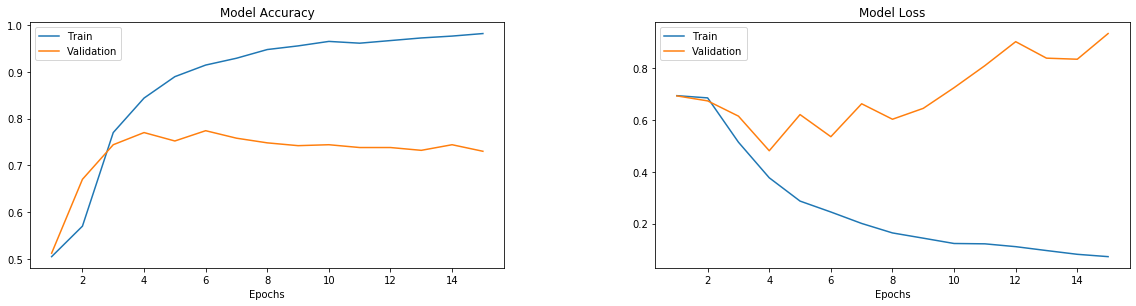

In [38]:
model_plots(model_logs, test_set="Validation")

Now let's calculate accuracy on all 3 datasets for a final comparison.  We see almost perfect accuracy on the train data (99%) and about 79% accuracy on the test data.

In [39]:
# Calculate accuracies (Takes 15-20 seconds to evaluate.)
from sklearn.metrics import accuracy_score

train_preds = rnn_model.predict(X_train_padded)
valid_preds = rnn_model.predict(X_valid_padded)
test_preds = rnn_model.predict(X_test_padded)

train_acc = accuracy_score(np.round(np.squeeze(train_preds)), y_train_rnn)
valid_acc = accuracy_score(np.round(np.squeeze(valid_preds)), y_valid_rnn)
test_acc = accuracy_score(np.round(np.squeeze(test_preds)), y_test_rnn)

print('Train acc: {:.3f}'.format(train_acc))
print('Valid acc: {:.3f}'.format(valid_acc))
print('Test acc: {:.3f}'.format(test_acc))

Train acc: 0.989
Valid acc: 0.730
Test acc: 0.790


### Findings

In summary, through both a rule-based approach and a RNN model, we were able to make reasonable predictions on the sentiment of a review.

The rule-based approach is easily understandable and yielded an accuracy of 73% on the test set, while the (much more complex) RNN model, improved our test set accuracy up to 79%.

Moving to a more complicated model did yield modest benefits (+6% accuracy), however depending on the use case for this model it may not be worth the added complexity.

In our case, chat bot deployment is probably OK to use the RNN model even though predictions may require an extra second or so to respond to the user (vs the rule-based approach, which is a bit quicker).